<a href="https://colab.research.google.com/github/taitsmp/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/linemen_on_knee_detection_yolov8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
%pip install ultralytics==8.0.77
%pip install echo1-coco-split
%pip install git+https://github.com/taitsmp/coco-to-yolo.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 513.4/513.4 kB 23.7 MB/s eta 0:00:00
  Cloning https://github.com/taitsmp/coco-to-yolo.git to /tmp/pip-req-build-gxsxe77n
  Running command git clone --filter=blob:none --quiet https://github.com/taitsmp/coco-to-yolo.git /tmp/pip-req-build-gxsxe77n
  Resolved https://github.com/taitsmp/coco-to-yolo.git to commit 4db16cc0886b40f18fdf5f58b748d4f0b56e69f8
  Preparing metadata (setup.py) ... done
  Created wheel for coco-to-yolo: filename=coco_to_yolo-0.1.5-py3-none-any.whl size=17608 sha256=85ce4deff132c796d23bef6166b1fe5b0fb62b9a6b8cd6a4a4c2348990ef62c1
  Stored in directory: /tmp/pip-ephem-wheel-cache-4bzzt5yc/wheels/0a/64/ca/05b497084c9a4182506c7c844249fd374a032633a71a182e19
Successfully built coco-to-yolo


In [1]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [2]:
import os
#os.environ['WANDB_MODE'] = 'disabled'

In [3]:
import wandb
from google.colab import userdata

wandb_key = userdata.get('wandb_key') #google colab secrets
wandb.login(key=wandb_key)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: telarson (fb-clips). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Variables

In [5]:
short_name = 'linemen-on-knee '
project_name = 'project-16' #internal project name related to label studio


img_sz = 1024
batch_size = 16
epochs = 100
patience = 25

coco_file = "linemen-on-knee.20241223_193349.coco.json"
mlops_project_name = f'{short_name}-detection' #used by wandb. Might be used by mlflow
model_arch = 'yolov8m'
model_name = f'{short_name}_{model_arch}'
base_drive_dir = '/content/drive/Othercomputers/My Mac/fb-clips-data-science'
model_root_path = f"{base_drive_dir}/models"
image_root_path = f"/content/{project_name}/football-videos-pre-snap"

COCO_FILE = f'{base_drive_dir}/annotations/{coco_file}'
DATASET_DIR = '/content/dataset'
IMAGE_ROOT = '/content/dataset/images'

# organization of training data should be...
'''
/content/dataset/
├── images/
├── train.json
└── val.json
'''

YOLO_DATASET_DIR = '/content/yolo_dataset'
YOLO_IMAGE_ROOT = f'{YOLO_DATASET_DIR}/images'

# we then move things into a yolo-friendly dataset directory using coco-to-yolo
'''
/content/yolo_dataset
├── images/
│   ├── train/      # Training images
│   └── val/        # Validation images
└── labels/
    ├── train/      # Training labels (*.txt files)
    └── val/        # Validation labels (*.txt files)
'''


'\n/content/yolo_dataset\n├── images/\n│   ├── train/      # Training images\n│   └── val/        # Validation images\n└── labels/\n    ├── train/      # Training labels (*.txt files)\n    └── val/        # Validation labels (*.txt files)\n'

## Copy Images From Remote Storage

In [7]:
## Copy the data
# Install rclone
!curl -s https://rclone.org/install.sh | sudo bash > /dev/null

# Setup rclone config
!mkdir -p ~/.config/rclone
!cp "/content/drive/Othercomputers/My Mac/fb-clips-data-science/config/rclone.conf" ~/.config/rclone/

# Create project directory
!mkdir -p {IMAGE_ROOT}

# Copy data from remote storage
!rclone copy r2-ml:fb-clips-ml/{project_name} {IMAGE_ROOT} \
    --checkers=128 \
    --transfers=128 \
    --fast-list \
    --buffer-size=16M \
    --bwlimit=off \
    --log-level=ERROR


In [6]:
!find {IMAGE_ROOT} -type f | wc -l

1018


## Split the Data

In [15]:
%cd {DATASET_DIR}
!coco-split --annotations_file "{COCO_FILE}" --valid_name val.json --valid_ratio 0.2 --test_ratio 0.0
%cd -

/content/dataset
Saved 208 annotations from 158 images to train.json
Saved 49 annotations from 40 images to val.json
/content


In [16]:
!coco_to_yolo {DATASET_DIR} {YOLO_DATASET_DIR} --images-dir {IMAGE_ROOT}


Input directory: /content/dataset
Output directory: /content/yolo_dataset
Images directory: /content/dataset/images
Mode: Object Detection

Found split files: ['train', 'val']

Processing train split...
Split: train
  Total images in annotations: 158
  Successfully processed: 158

Category ID mapping (original -> YOLO):
  Linemen on a knee: 2 -> 0

Processing val split...
Split: val
  Total images in annotations: 40
  Successfully processed: 40

Category ID mapping (original -> YOLO):
  Linemen on a knee: 2 -> 0

Conversion complete!
Dataset created at: /content/yolo_dataset

Final Class Mapping Summary:
---------------------------
YOLO ID | Original ID | Class Name
---------------------------
      0 |          2 | Linemen on a knee
---------------------------


## Configure Training

In [17]:
%%writefile {YOLO_DATASET_DIR}/data.yaml

path: /content/yolo_dataset

train: images/train
val: images/val

names: [ "Linemen on a knee"]

Writing /content/yolo_dataset/data.yaml


In [7]:
augmentation_params =  {
    'hsv_h': 0.5,       # ±30% hue variation (±36 degrees) for different uniforms
    'hsv_s': 0.5,       # ±30% saturation for lighting changes
    'hsv_v': 0.2,       # ±20% brightness variation
    'degrees': 4.0,
    'translate': 0.05,  # Minimal translation
    'scale': 0.2,
    'fliplr': 0.4,
    'mosaic': 0.0,      # No mosaic
    'mixup': 0.0,       # No mixup
    'copy_paste': 0.0,  # No copy-paste
    'perspective': 0.0001, # Slight perspective change
}

## Train

In [8]:
from ultralytics import YOLO

model_arch = 'yolov8m'

model = YOLO(f'{model_arch}.pt')

results = model.train(
    data=f'{YOLO_DATASET_DIR}/data.yaml',
    epochs=epochs,
    imgsz=img_sz,
    batch=batch_size,
    **augmentation_params,
    name=model_name,
    #wandb params below
    project=mlops_project_name,
    save_period=12,
)




/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py:347: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file, map_location='cpu'), file  # load


AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py:347: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental f

## Copy the Model

In [9]:
import re
from datetime import datetime

date_match = re.search(r'at-(\d{4}-\d{2}-\d{2})', coco_file)
date_mtch2 = re.search(r'-(\d{4}\d{2}\d{2})_(\d+)', coco_file)
if date_match:
    # Convert the matched date string to datetime and reformat
    date_suf = datetime.strptime(date_match.group(1), '%Y-%m-%d').strftime('%Y%m%d')
    model_fullname = f"{model_name}-{date_suf}.pt"
elif date_mtch2:
    # Convert the matched date string to datetime and reformat
    date_suf = date_mtch2.group(1)
    extra_suf = date_mtch2.group(2)
    model_fullname = f"{model_name}-{date_suf}_{extra_suf}.pt"
else:
    # Fallback to current date if pattern not found
    date_suf = datetime.now().strftime('%Y%m%d')
    model_fullname = f"{model_name}-{date_suf}.pt"

best_model_path = str(model.trainer.best)

In [10]:
best_model_path

'linemen-on-knee -detection/linemen-on-knee _yolov8m2/weights/best.pt'

In [11]:
import shutil
import os

def copy_with_versioning(source_path, dest_path):
    """
    Copy a file to the destination path. If a file with the same name exists,
    append a version number (e.g., .2, .3) before the file extension.
    """
    base, ext = os.path.splitext(dest_path)
    version = 1

    while os.path.exists(dest_path):
        version += 1
        if version > 9:
            raise Exception("Exceeded single digit version limits")
        dest_path = f"{base}.{version}{ext}"

    shutil.copy(source_path, dest_path)
    return dest_path

source_path = best_model_path  # Path to the source file
dest_path = f"{model_root_path}/{model_fullname}"  # Destination path

gd_loc = copy_with_versioning(source_path, dest_path)

In [12]:
print(f'copied model to {gd_loc}')

copied model to /content/drive/Othercomputers/My Mac/fb-clips-data-science/models/linemen-on-knee _yolov8m-20241224.pt


## Visualize Results

In [13]:
import os
import re
from pathlib import Path

def get_last_run_folder(base_path=f'/content/{mlops_project_name}/{model_name}'):
    # Get the parent directory of the provided path
    parent_dir = os.path.dirname(base_path)

    # Extract the base pattern from the provided base_path
    base_pattern = os.path.basename(base_path)
    base_regex = re.escape(base_pattern) + r'\d*$'

    # Get all subdirectories in the parent directory
    folders = [
        d for d in os.listdir(parent_dir)
        if os.path.isdir(os.path.join(parent_dir, d)) and re.match(base_regex, d)
    ]

    if folders:
        # Sort numerically by trailing numbers and take the last one
        return sorted(
            folders,
            key=lambda x: int(re.findall(r'\d+$', x)[0]) if re.findall(r'\d+$', x) else 0
        )[-1]

    # If no folders found, return None
    return None

train_folder = get_last_run_folder()

In [14]:
# TODO: remove me.
train_folder

'linemen-on-knee _yolov8m2'

In [15]:
import base64
from IPython.display import Image, display, HTML


def embed_image(image_path):
    with open(image_path, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read()).decode()
    return f"""
    <div>
        <img
            src="data:image/jpeg;base64,{encoded_string}"
            style="max-width: 800px"
        />
    </div>
    """


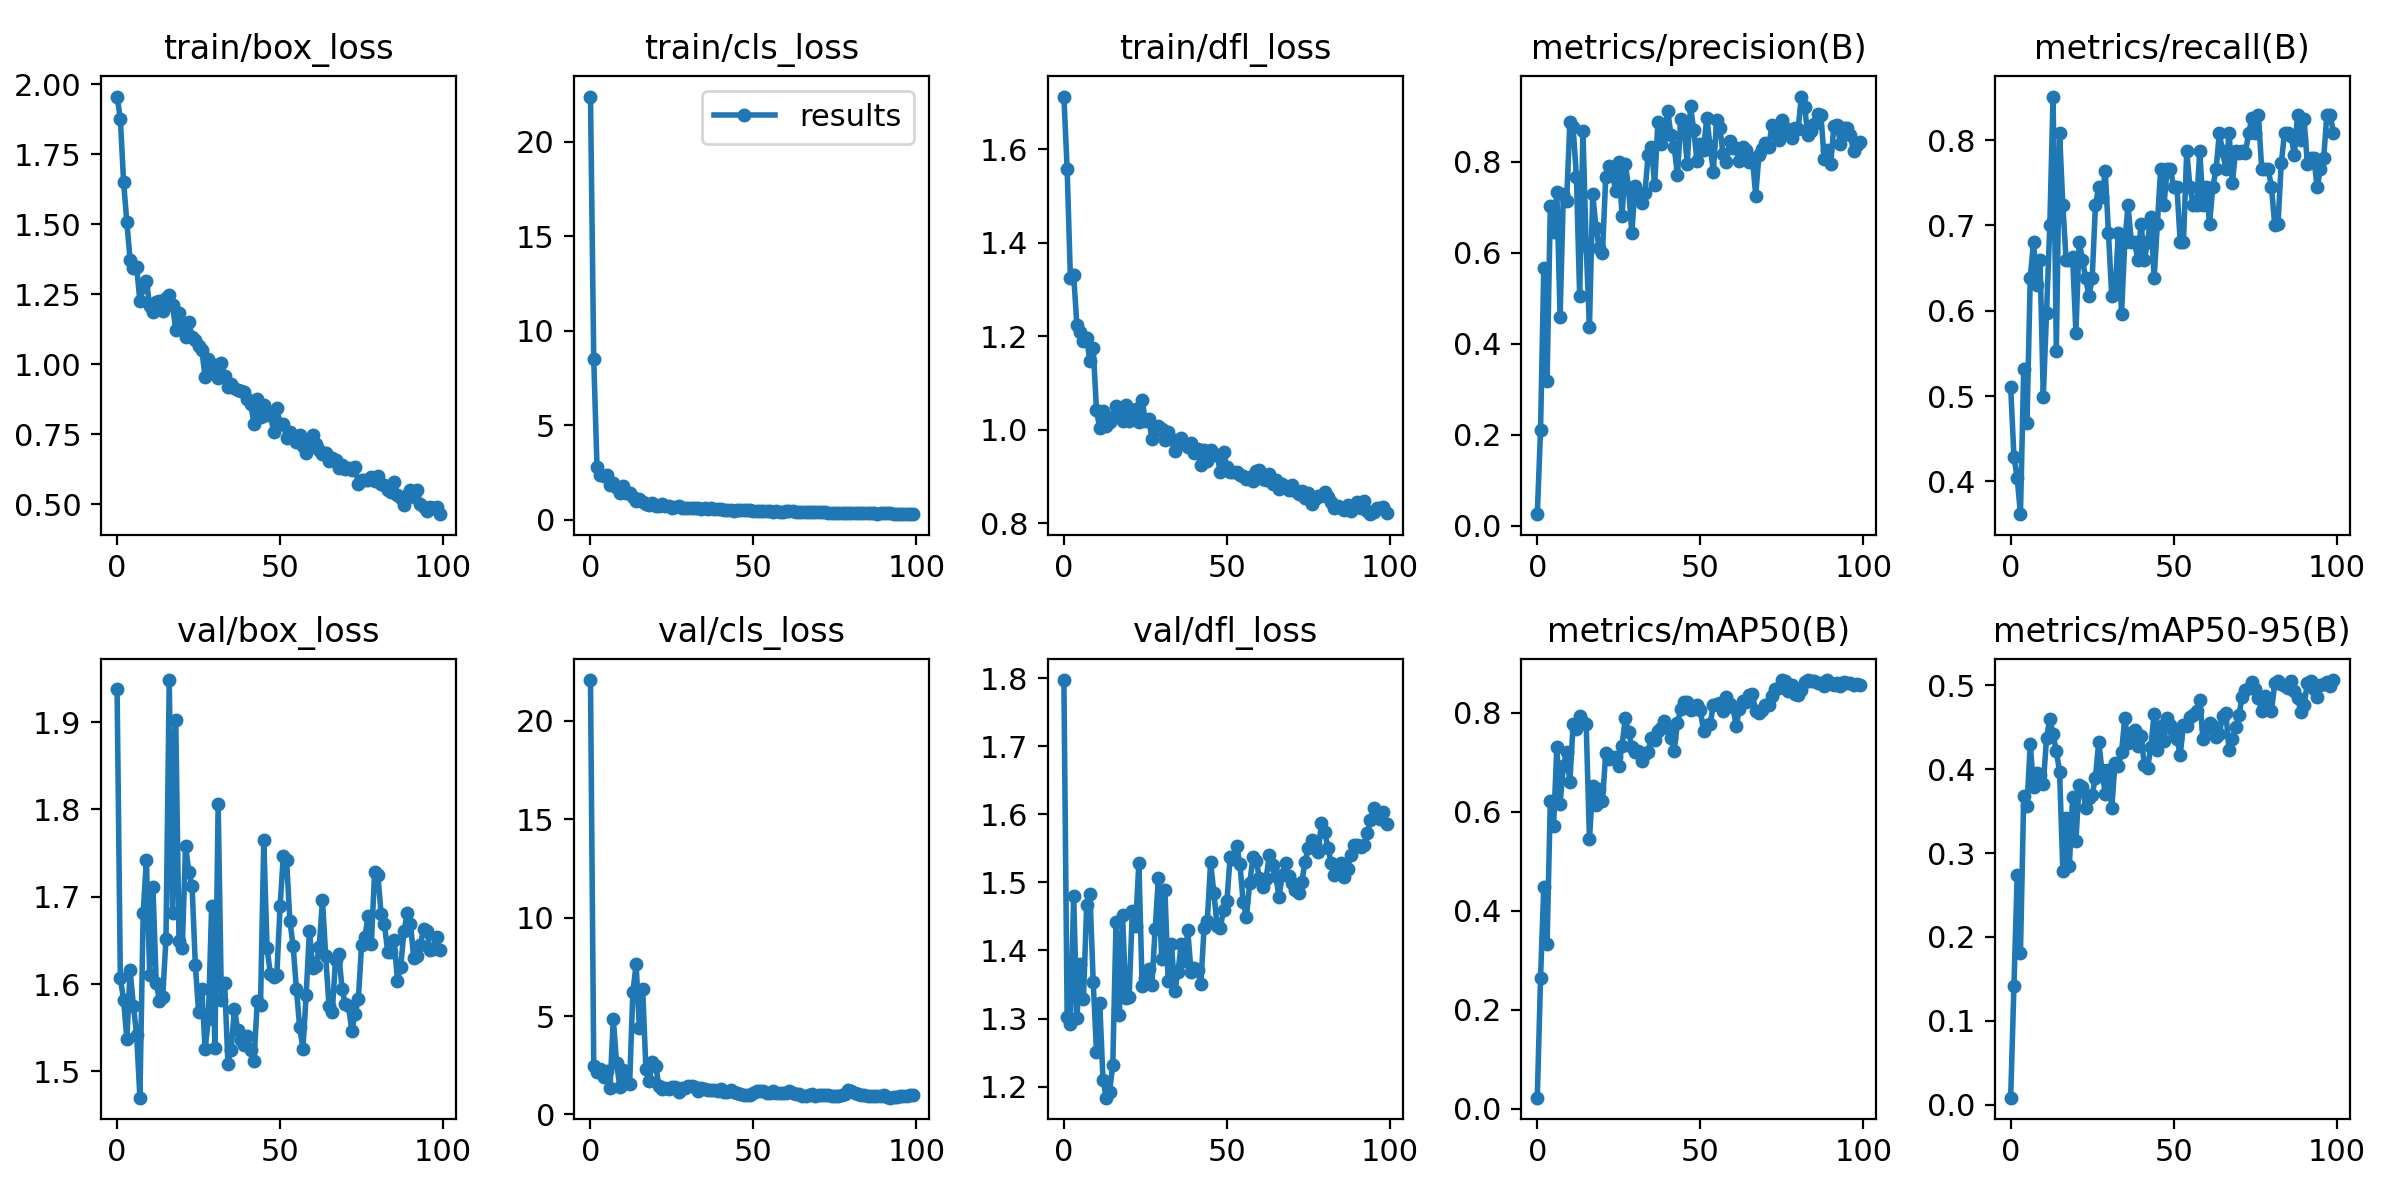

In [16]:

HTML(embed_image(image_path=f'/content/{mlops_project_name}/{train_folder}/results.png'))


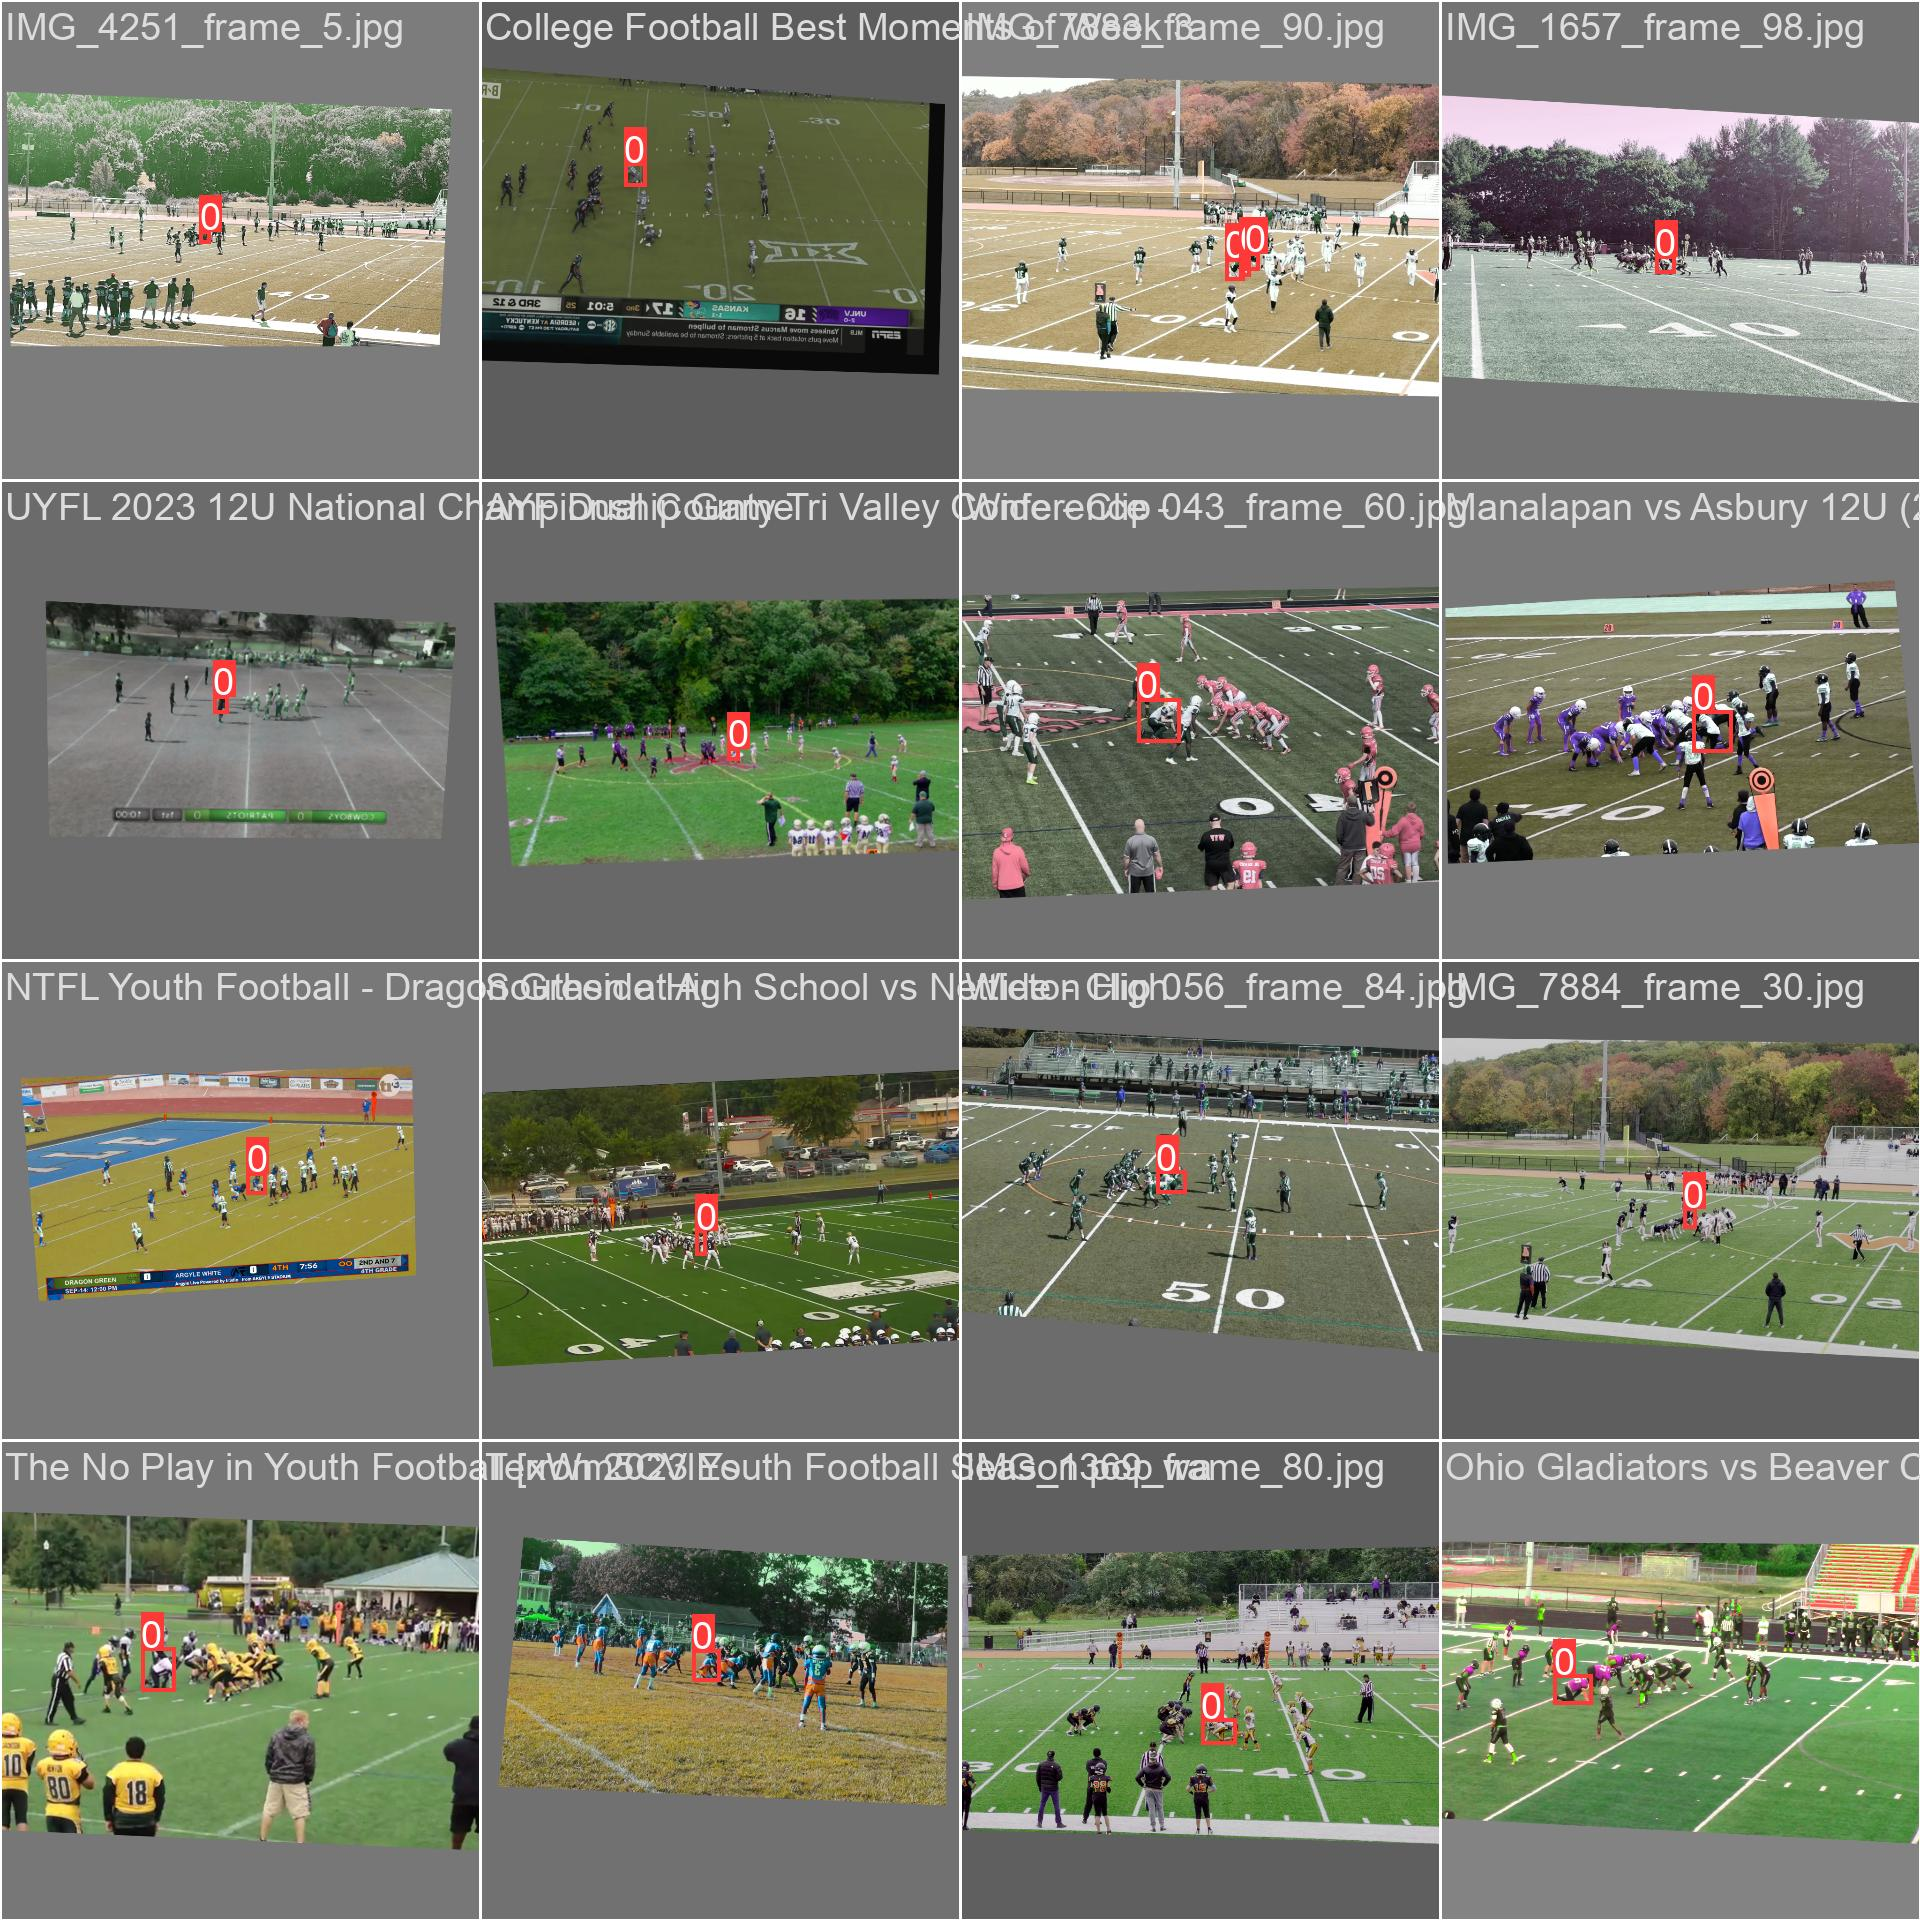

In [17]:
HTML(embed_image(image_path=f'/content/{mlops_project_name}/{train_folder}/train_batch0.jpg'))



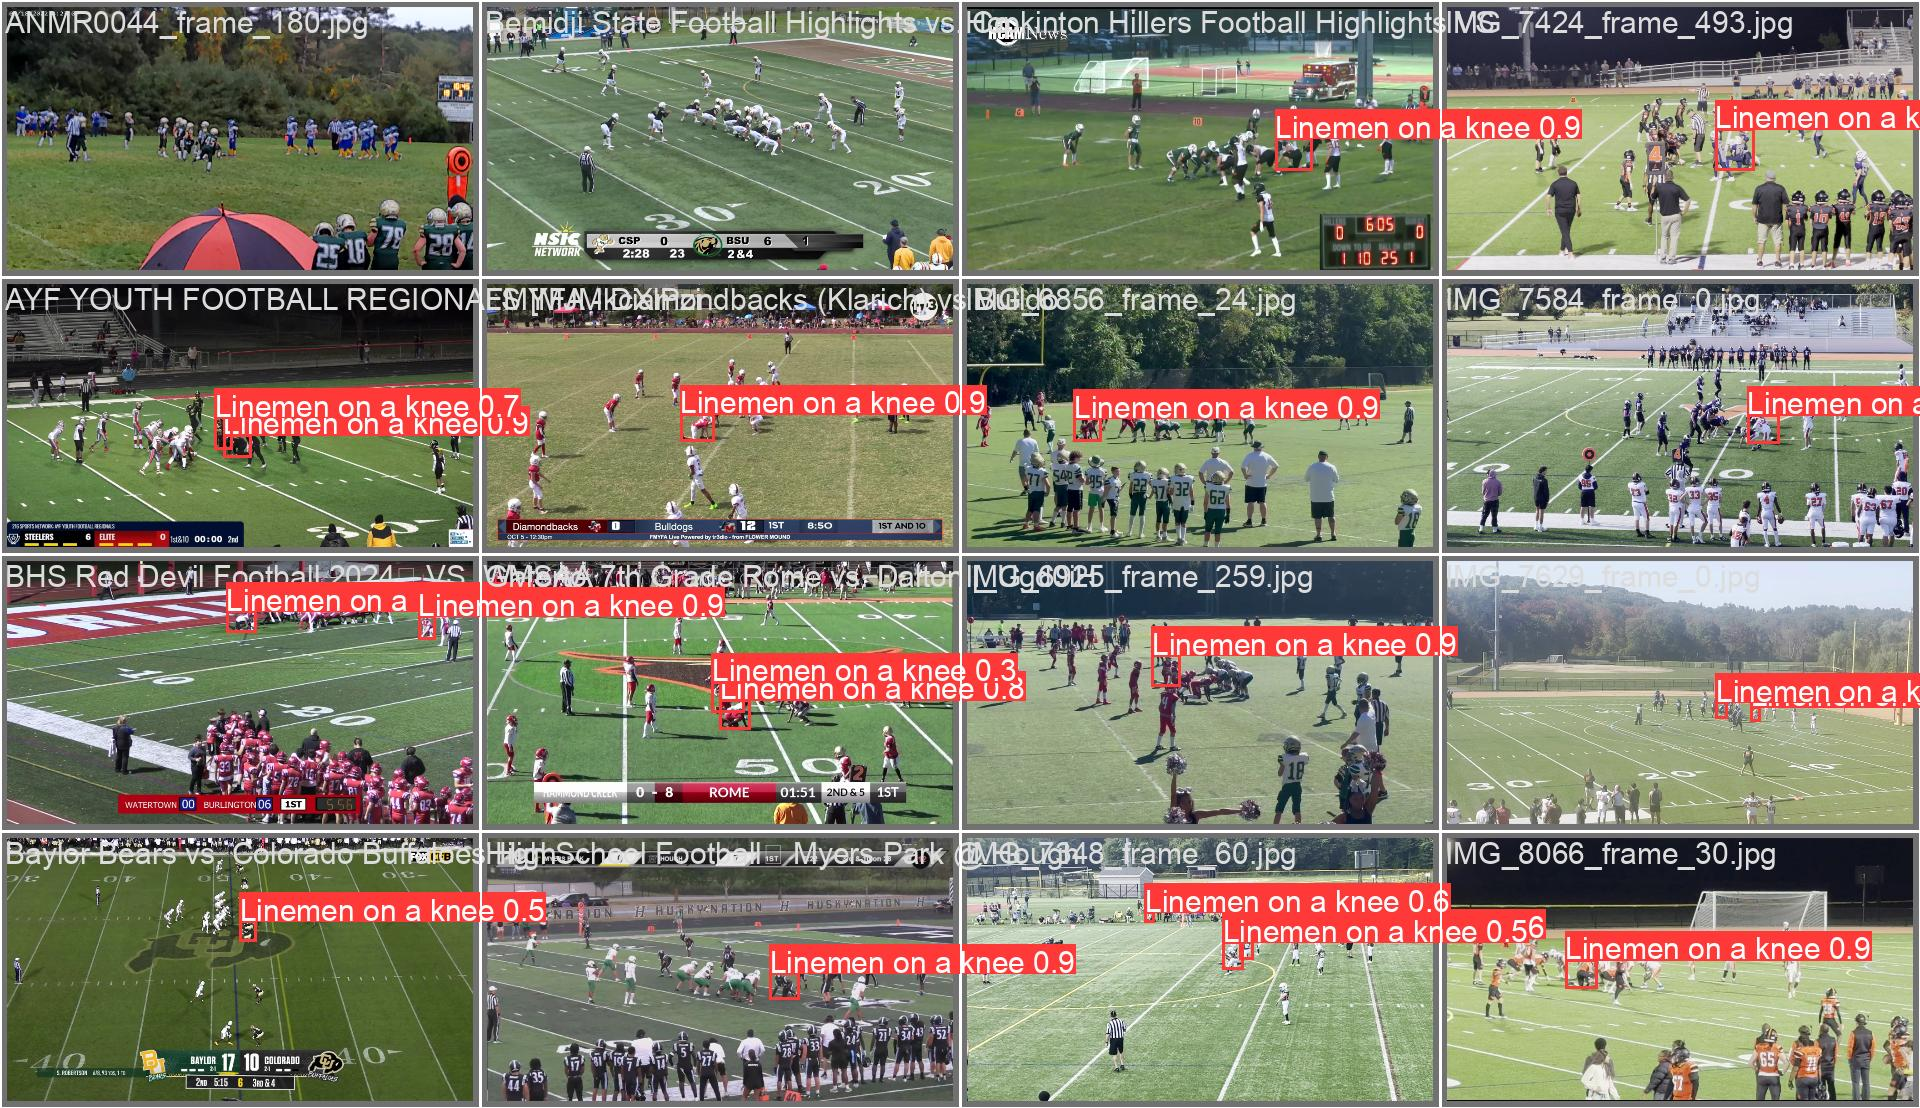

In [18]:
HTML(embed_image(f'/content/{mlops_project_name}/{train_folder}/val_batch0_pred.jpg'))



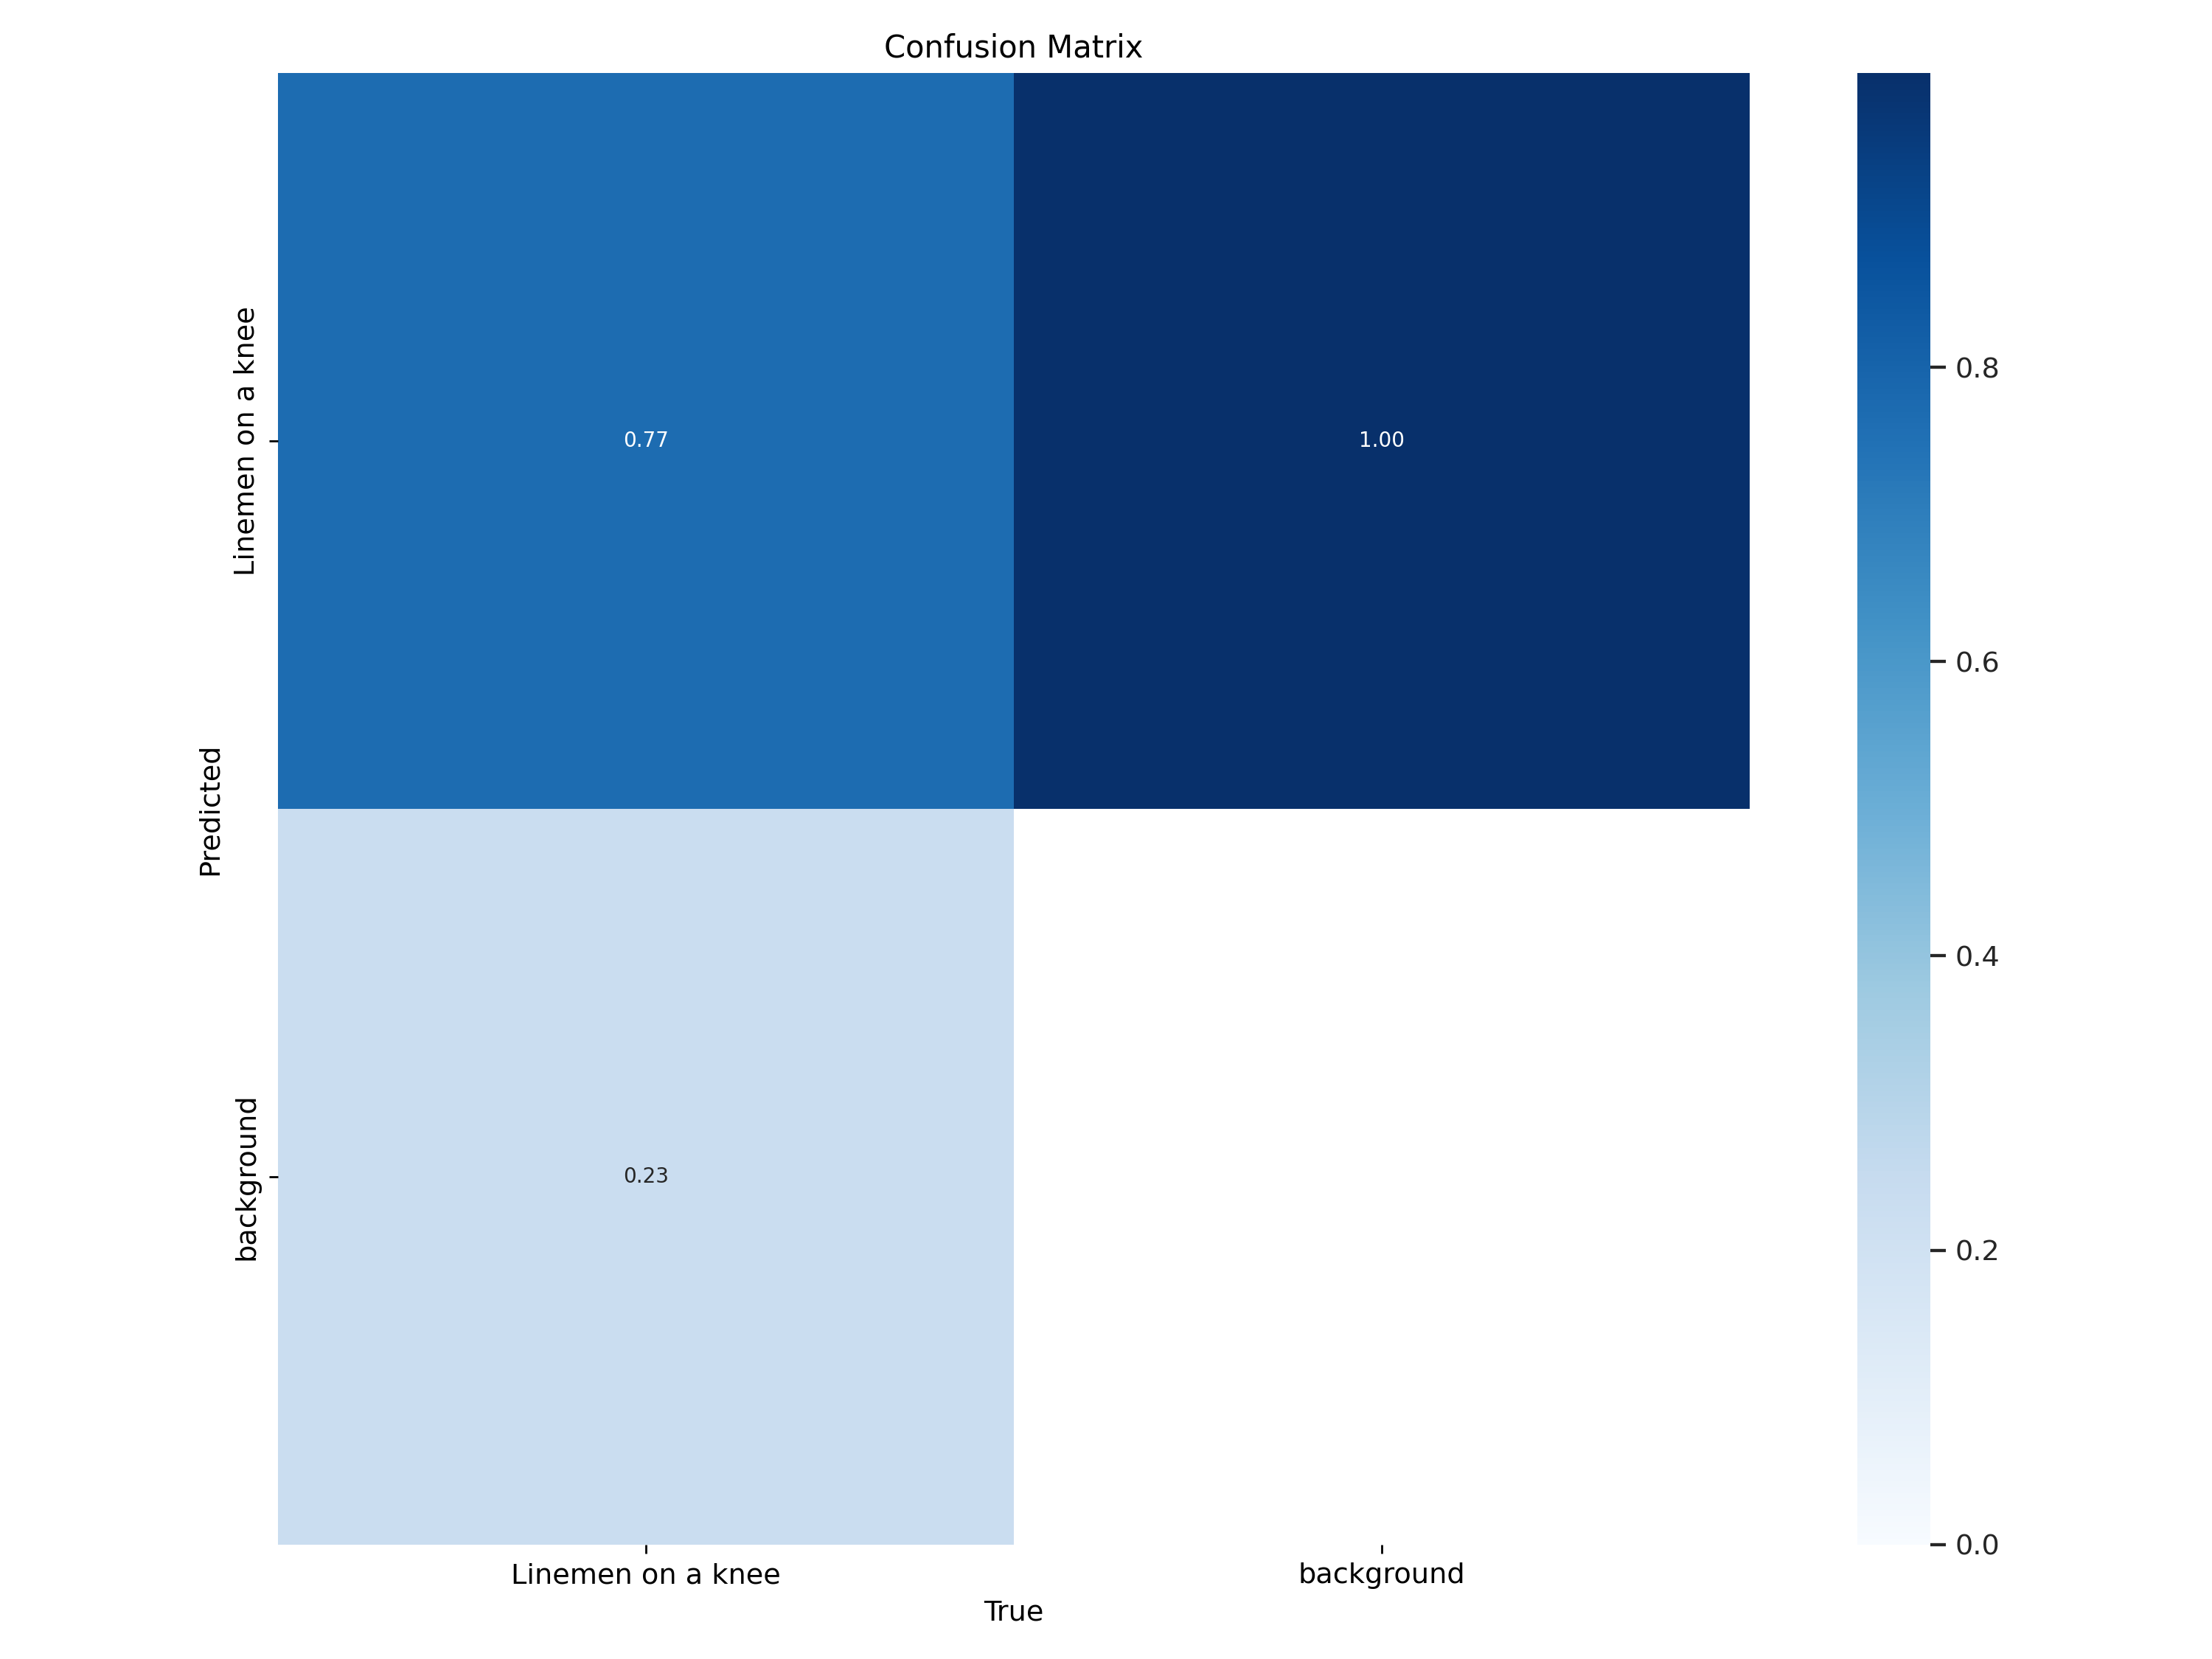

In [20]:
HTML(embed_image(f'/content/{mlops_project_name}/{train_folder}/confusion_matrix.png'))